<a href="https://colab.research.google.com/github/sceddd/TrafficLightVisual/blob/main/track_and_detect_with_roboflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yolov8 in count object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
HOME = os.getcwd()

!pip install ultralytics 
!pip install roboflow --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Install requirement lib for supervision

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack
!pip install -q -r requirements.txt
!pip install thop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112
!pip install -q loguru lap

/content/ByteTrack
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 18.51 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
/content/ByteTrack/ByteTrack
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
^C
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    fr

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from IPython.display import clear_output
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.7/107.7 GB disk)


In [ ]:
!pip install supervision==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3099, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most rec

#Add roboflow dataset

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key='wJB8Y6GudjCCjIw5qXLf')
# project = rf.workspace('sceddd').project("vehicle-model-hb3ou")
# dataset = project.version(1).download("yolov8")

In [ ]:
# %cd {HOME}
# !yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs = 15 imgsz = 225

In [ ]:
# !ls {HOME}/runs/detect/train

In [ ]:
# from PIL import Image

# def displayImage(filepath):
  # img = Image.open(filepath)
  # img.show()

In [ ]:
# %cd {HOME}
# displayImage(f"{HOME}/runs/detect/train/confusion_matrix.png")

In [ ]:
# displayImage('/content/runs/detect/train8/val_batch0_labels.jpg')

In [ ]:
# displayImage('/content/runs/detect/train/results.png')

#Detect Traffic

##ByteTracker preprocessing for YOLOv8

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
clear_output()
import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.7.0


In [ ]:
# settings
from ultralytics import YOLO
# traffic light detections
MODEL = "/content/drive/MyDrive/best.pt"
TLmodel = YOLO(MODEL)

In [ ]:
TLmodel.fuse()
LIGHT_COLOR = TLmodel.model.names

In [ ]:
#traffic detection
trafficModel = YOLO('yolov8n.pt')
trafficModel.fuse()

100%|██████████| 6.23M/6.23M [00:00<00:00, 144MB/s]
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [ ]:
CLASS_NAMES_DICT = trafficModel.model.names
CLASS_NAMES_DICT

In [ ]:
TRANSPORTATION_ID = [1, 2, 3, 5, 7]
for i in TRANSPORTATION_ID:
  print(CLASS_NAMES_DICT[i])

bicycle
car
motorcycle
bus
truck


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.core import Point
from supervision.video import VideoInfo,VideoSink,get_video_frames_generator
from supervision.notebook.utils import plot_image
from supervision.detection.core import Detections
from supervision.detection.annotate import BoxAnnotator
from supervision.detection.line_counter import LineZone, LineZoneAnnotator
from tqdm.notebook import tqdm
from supervision import process_video
import numpy as np

In [ ]:
from typing import List

import numpy as np

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
from supervision.geometry.core import Vector
from typing import Dict, Optional 
from typing import Dict

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color
from supervision.geometry.core import Point, Rect, Vector
from typing import Optional

class LineZoneFixed:
  def __init__(self, start: Point, end: Point, grace_period: int = 30):
    self.vector = Vector(start=start, end=end)
    self.tracker_state: Dict[str, bool] = {}
    self.already_counted: Dict[str, bool] = {} # Flag for each tracker_id
    self.frame_last_seen: Dict[str, int] = {} # Last frame each tracker_id was encountered
    self.current_frame: int = 0 # Current frame counter
    self.in_count: int = 0
    self.out_count: int = 0
    self.grace_period = grace_period # Number of frames to wait before resetting
  def is_within_line_segment(self, point: Point, margin: float = 5) -> bool:
    """
    Check if a point is within the line segment.

        Attributes:
            point (Point): The point to be checked.
            margin (float): Additional margin added to the line segment boundaries.

        Returns:
            bool: True if the point is within the line segment, False otherwise.
    """
    x_within = min(self.vector.start.x, self.vector.end.x) - margin <= point.x <= max(self.vector.start.x, self.vector.end.x) + margin
    y_within = min(self.vector.start.y, self.vector.end.y) - margin <= point.y <= max(self.vector.start.y, self.vector.end.y) + margin

    return x_within and y_within

  def trigger(self, detections: Detections):
      self.current_frame += 1  # Increment frame counter

      for xyxy, _, confidence, class_id, tracker_id in detections:
          # handle detections with no tracker_id
          if tracker_id is None:
              continue

          # we check if the bottom center anchor of bbox is on the same side of vector
          x1, y1, x2, y2 = xyxy
          anchor = Point(x=(x1+x2)/2, y=y2)  # Bottom center point of bounding box

          # Check if anchor is within the line segment
          if not self.is_within_line_segment(anchor):
              continue

          tracker_state = self.vector.is_in(point=anchor)

          # handle new detection
          if tracker_id not in self.tracker_state:
              self.tracker_state[tracker_id] = tracker_state
              self.already_counted[tracker_id] = False  # When the object appears, it has not been counted yet
              self.frame_last_seen[tracker_id] = self.current_frame  # Update last seen frame
              continue

          # handle detection on the same side of the line
          if self.tracker_state.get(tracker_id) == tracker_state:
              continue

          # check if this crossing has already been counted
          if self.already_counted.get(tracker_id, False):  # If it has been counted, we skip this
              # Check if grace period has passed since last encounter
              if self.current_frame - self.frame_last_seen.get(tracker_id, 0) > self.grace_period:
                  self.already_counted[tracker_id] = False  # Reset after grace period
              else:
                  continue

          self.tracker_state[tracker_id] = tracker_state
          self.already_counted[tracker_id] = True  # After counting, we mark this crossing as already counted
          self.frame_last_seen[tracker_id] = self.current_frame  # Update last seen frame

          if tracker_state:
              self.in_count += 1
          else:
              self.out_count += 1

In [ ]:
#source to choose video
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/Camera-Giao-Thong/14-05-2023/camera1.mp4"
OUTPUT_VIDEO_PATH = f"/content/drive/MyDrive/Camera-Giao-Thong/output/vehicle-counting-result1.mp4"

##Create lines object for detect multiple lines

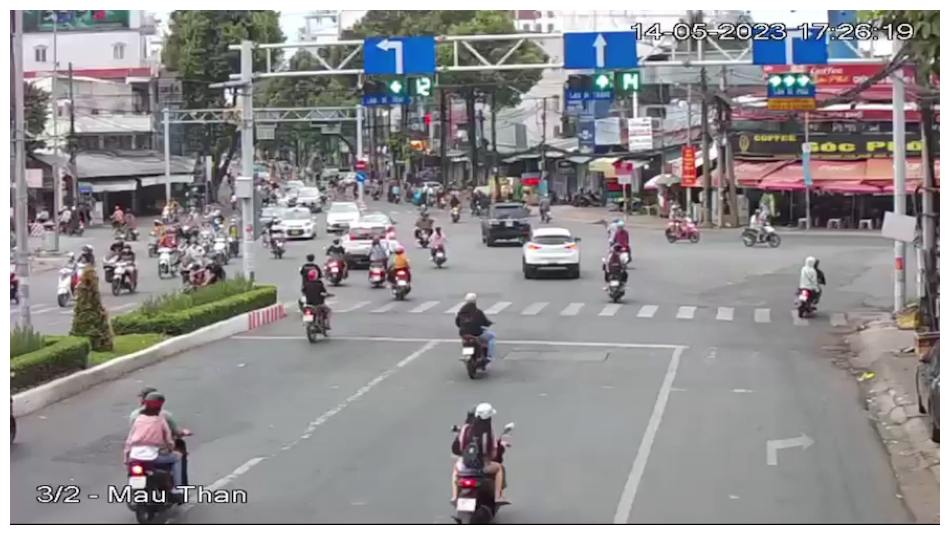

In [ ]:
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
plot_image(frame)

In [ ]:
#position of line TODO: detect road surface marking to draw line
LINES = [[Point(220, 310),Point(850, 310)],[Point(860,310),Point(795,190)],[Point(550,179),Point(180,180)]]


In [ ]:
color = ColorPalette.default()
lines = [
    LineZoneFixed(start=x,end=y)
    for x,y
    in LINES
]
lines_annotator = [
    LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=2)
    for index in range(len(lines))
]
box_annotator = BoxAnnotator(thickness = 1, text_thickness = 2,text_scale=2)
byte_tracker = BYTETracker(BYTETrackerArgs())

In [ ]:
def process_transportation(frame: np.ndarray, i) -> np.ndarray:
    # detect
    results = trafficModel(frame)[0]
    detections = Detections.from_yolov8(results)
    # annotate and display frame
    mask = np.array([class_id in TRANSPORTATION_ID for class_id in detections.class_id], dtype=bool)
    detections = detections[mask]
    # tracking detections
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)
    # filtering out detections without trackers
    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections = detections[mask]
    labels = [
      f"#{tracker_id}"
      for _,_,confi,class_id,tracker_id 
      in detections
    ]
    frame = box_annotator.annotate(scene=frame,detections=detections,labels = labels)
    for line,line_annotator in zip(lines,lines_annotator):
      # settings
      line.trigger(detections = detections)
      frame = line_annotator.annotate(frame=frame,line_counter=line)
    return frame


0: 384x640 9 persons, 7 cars, 13 motorcycles, 128.0ms
Speed: 2.6ms preprocess, 128.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


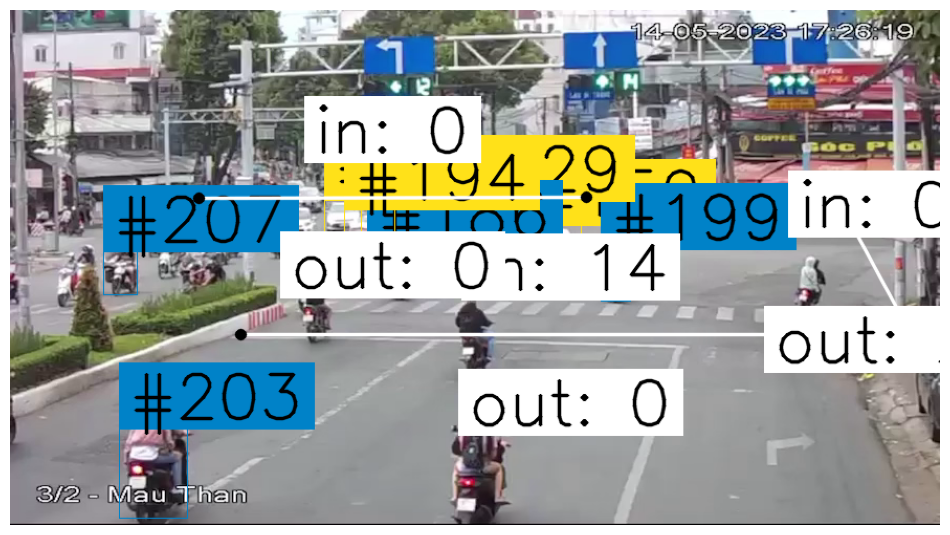

In [ ]:
plot_image(process_transportation(frame,1))

#Detect traffic light

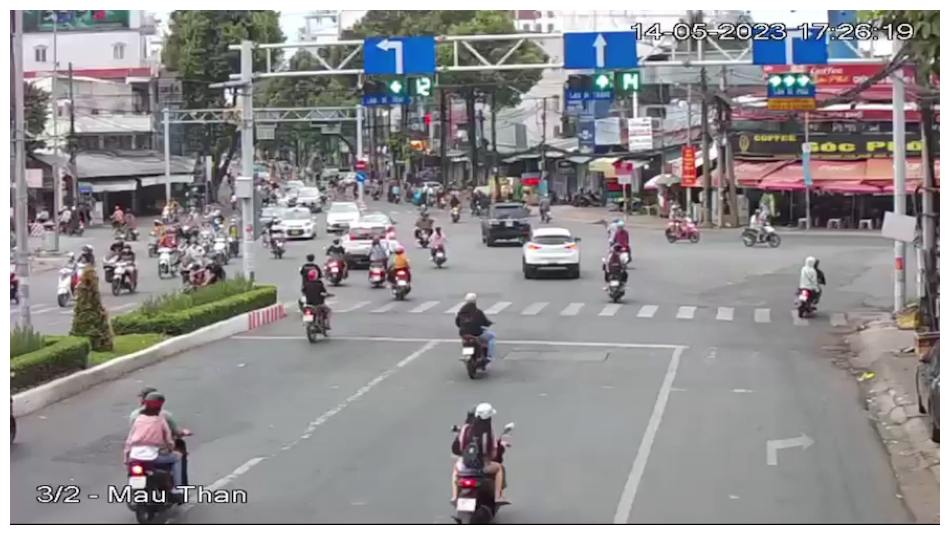

In [ ]:
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
plot_image(frame)
trafficLight_annotator = BoxAnnotator(thickness = 1, text_thickness = 2,text_scale=2)

In [ ]:
def update():
  """
  Update the counting whenever the traffic light change color

  """
  for line in lines:
    line.in_count = 0

In [ ]:
def detectColor(frame:np.ndarray,xyxy:np.ndarray) -> str:
  """
  Detect traffic light's color

  Args:
  frame(np.ndarray): The image contain the detections to check it color
  xyxy (np.ndarray): An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
  """
  crop_image(frame,xyxy)
  

In [ ]:
def crop_image(image: np.ndarray, xyxy: np.ndarray) -> List[np.ndarray]:
  xyxy = [round(elem) for elem in xyxy ]
  x1,y1,x2,y2 = xyxy
  cropped_image = image[y1:y2,x1:x2]
  return cropped_image
def process_trafficLight(frame: np.ndarray, i) -> np.ndarray:
  TF_results = TLmodel(frame)[0]
  detections = Detections.from_yolov8(TF_results)
  tracks = byte_tracker.update(
      output_results=detections2boxes(detections=detections),
      img_info=frame.shape,
      img_size=frame.shape
  )
  tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
  print(tracker_id)
  detections.tracker_id = np.array(tracker_id)
  mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
  detections = detections[mask]
  labels = [//
      f"#{tracker_id}{class_id}"
      for _,_,confi,class_id,tracker_id 
      in detections
  ]
  trafficLight_annotator.annotate(scene=frame, detections = detections,labels = labels)
  # for i,xyxy in enumerate(detections.xyxy):
  #   detectColor(frame,xyxy)
  return frame


0: 448x800 3 reds, 462.1ms
Speed: 3.4ms preprocess, 462.1ms inference, 1.1ms postprocess per image at shape (1, 3, 800, 800)


[]


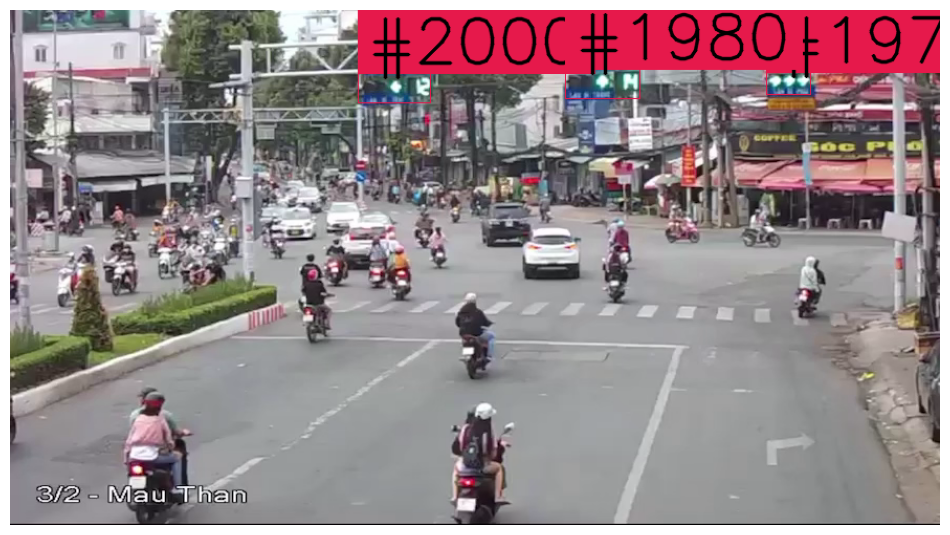

In [ ]:
plot_image(process_trafficLight(frame,1))


0: 448x800 7 greens, 479.1ms
Speed: 5.0ms preprocess, 479.1ms inference, 0.9ms postprocess per image at shape (1, 3, 800, 800)


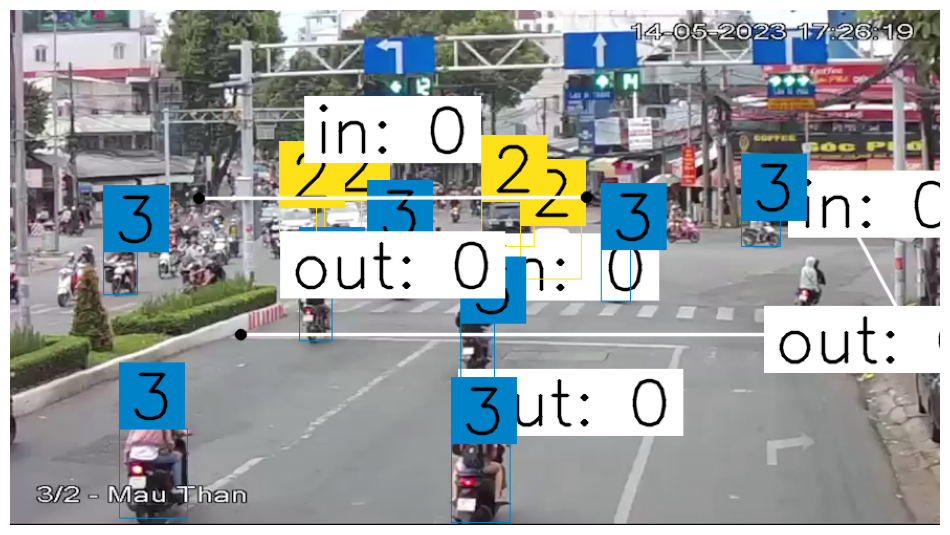

In [ ]:
plot_image(process_trafficLight(frame,1))

In [ ]:
from typing import Callable
def process_video(
    source_path: str,
    target_path: str,
    callback: Callable[[np.ndarray, int], np.ndarray],
) -> None:
    """
    Process a video file by applying a callback function on each frame and saving the result to a target video file.

    Args:
        source_path (str): The path to the source video file.
        target_path (str): The path to the target video file.
        callback (Callable[[np.ndarray, int], np.ndarray]): A function that takes in a numpy ndarray representation of a video frame and an int index of the frame and returns a processed numpy ndarray representation of the frame.

    Examples:
        ```python
        >>> from supervision import process_video

        >>> def process_frame(scene: np.ndarray) -> np.ndarray:
        ...     ...

        >>> process_video(
        ...     source_path='source_video.mp4',
        ...     target_path='target_video.mp4',
        ...     callback=process_frame
        ... )
        ```
    """
    source_video_info = VideoInfo.from_video_path(video_path=source_path)
    with VideoSink(target_path=target_path, video_info=source_video_info) as sink:
        for index, frame in enumerate(
            get_video_frames_generator(source_path=source_path)
        ):
            result_frame = callback(frame, index)
            if index % sink.video_info.fps==0:
              process_trafficLight(frame,index)
            sink.write_frame(frame=result_frame)

#Detect and count object


0: 384x640 9 persons, 7 cars, 13 motorcycles, 109.3ms
Speed: 2.9ms preprocess, 109.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


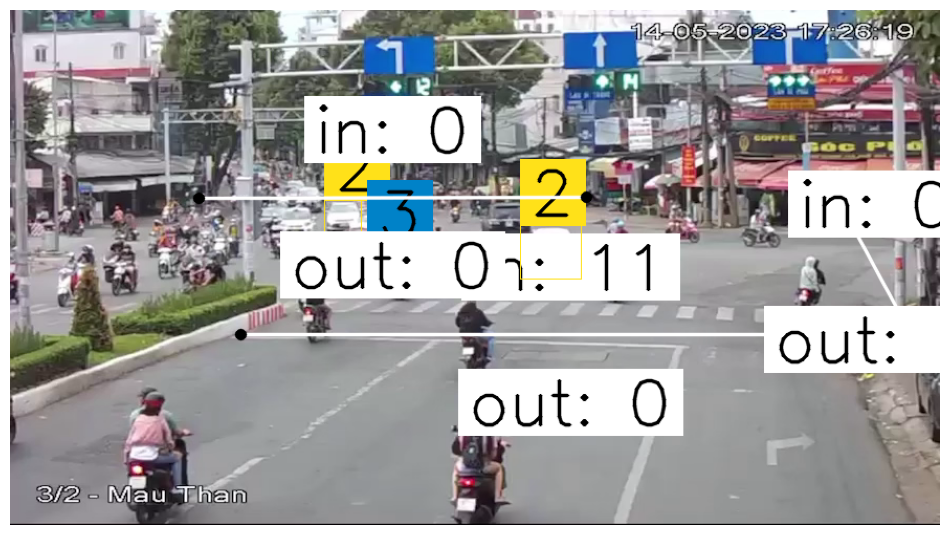


0: 384x640 7 persons, 7 cars, 12 motorcycles, 155.8ms
Speed: 2.3ms preprocess, 155.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 7 cars, 12 motorcycles, 117.9ms
Speed: 2.3ms preprocess, 117.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 7 cars, 11 motorcycles, 115.1ms
Speed: 2.3ms preprocess, 115.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 7 cars, 14 motorcycles, 122.5ms
Speed: 2.2ms preprocess, 122.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 6 cars, 13 motorcycles, 113.3ms
Speed: 2.6ms preprocess, 113.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 6 cars, 14 motorcycles, 122.7ms
Speed: 2.2ms preprocess, 122.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 9 persons, 5 cars, 13 motorcycles, 117.9ms
Speed: 2.3ms preprocess, 11

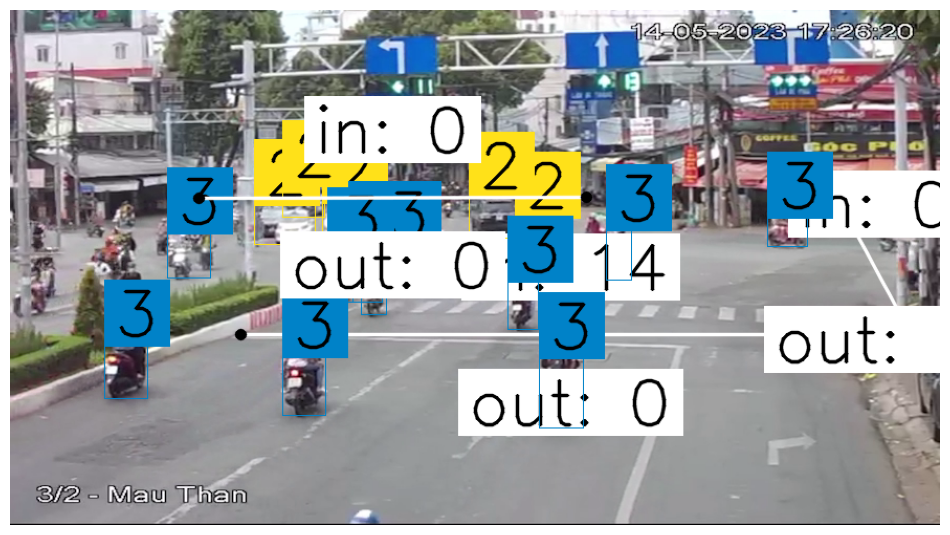


0: 384x640 6 persons, 6 cars, 13 motorcycles, 151.9ms
Speed: 2.6ms preprocess, 151.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 6 persons, 6 cars, 13 motorcycles, 122.2ms
Speed: 3.1ms preprocess, 122.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 6 persons, 6 cars, 12 motorcycles, 121.7ms
Speed: 2.2ms preprocess, 121.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 6 persons, 6 cars, 13 motorcycles, 134.1ms
Speed: 2.3ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 persons, 7 cars, 13 motorcycles, 117.2ms
Speed: 2.9ms preprocess, 117.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 persons, 6 cars, 13 motorcycles, 111.7ms
Speed: 2.5ms preprocess, 111.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 persons, 7 cars, 13 motorcycles, 123.1ms
Speed: 2.3ms preprocess, 12

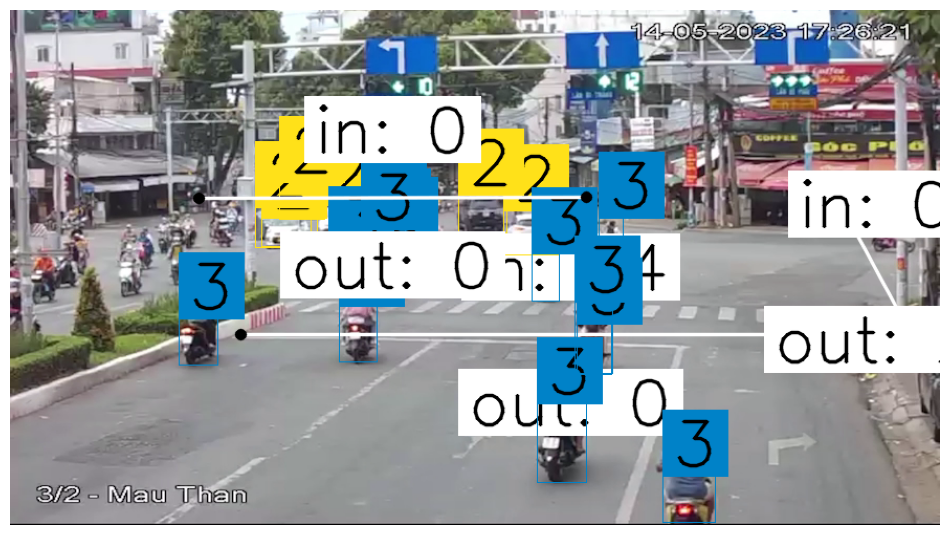


0: 384x640 10 persons, 6 cars, 16 motorcycles, 156.7ms
Speed: 2.4ms preprocess, 156.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 9 persons, 6 cars, 16 motorcycles, 165.1ms
Speed: 2.3ms preprocess, 165.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 9 persons, 6 cars, 16 motorcycles, 184.5ms
Speed: 4.4ms preprocess, 184.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 9 persons, 6 cars, 16 motorcycles, 180.9ms
Speed: 2.3ms preprocess, 180.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 9 persons, 6 cars, 14 motorcycles, 164.5ms
Speed: 2.8ms preprocess, 164.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 6 cars, 12 motorcycles, 174.7ms
Speed: 2.6ms preprocess, 174.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 7 persons, 6 cars, 12 motorcycles, 163.4ms
Speed: 2.9ms preprocess, 1

KeyboardInterrupt: ignored

In [ ]:
process_video(source_path=SOURCE_VIDEO_PATH, target_path=OUTPUT_VIDEO_PATH, callback=process_transportation)